### Carbon stock determination of a droughted Pinon-Juniper woodland using structure from motion
##### Dan J. Krofcheck, Christopher Lippitt, Marcy E. Litvak (Jesse and Su and ...?)
Low cost photogrammetry projects from either manned or unmanned aircraft can leverage high image overlap to produce 3-dimensional point clouds of surface features, interpolate ground terrain, and gain some crude multi-spectral capabilities such as pseudo-NDVI with the use of makeshift filters. 

Here we test the ability of SfM data to characterize the distribution of C stocks across a PJ woodland, and subsequently bin the biomass estimates into live and dead carbon pools.

Analysis requirements:
    1. Use ground measurements and allometries to create a volume to biomass 
        relationship for P and J
    2. Perturb this relationship for varying degrees of P mortality
    3. Characterize the SfM to ground volume uncertainty
    4. propagate uncertainty from P mortality and volume:volume 
        relationship into SfM volume to ground biomass relationship
    5. Conduct a segmentation on the SfM data
    6. Determine vegetation status (live / dead) using pseudo NDVI for each segment
    7. Apply allometry to each segment, if segment is dead, subtract foliar biomass 
        component

#### Load required libraries

In [36]:
# ------- Notebook config
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import os, osr, gdal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# Data Input Dir
dataIn = 'Y:/DanK/DeerCanyon/Analysis_get/'
# Output Dir:
dataOut ='Y:/DanK/DeerCanyon/Analysis_put/'


#### Function definition

In [38]:
# IO
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

# Ground data plots -- curve fit process
def linearFit(x, yparams, **kwargs):
    return coeffs, rmse, resid

def plotFit(x, coefs, confInt):
    return plot

def dropData(x, yparams, **kwargs):
    return subsetOfData

# Segmentation classification
def defineStatus(segmentation, attributes, fourBandRaster):
    return ndviRaster, liveDeadRaster, attributesModified

# Biomass designation
def calculteBiomass(segmentation, attributesModified, liveDeadRaster):
    return biomassRaster 

# Raster visualization
def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Vector visualization
def getShpGeom(shapefile):
    shp = fiona.open(shapefile)
    bds = shp.bounds
    shp.close()
    padLON = ((bds[0] - bds[2]) / 2) * 0.05
    padLAT = ((bds[1] - bds[3]) / 2) * 0.05
    ll = (bds[0] + padLON, bds[1] + padLAT)
    ur = (bds[2] - padLON, bds[3] - padLAT)
    midlat = (bds[1] + bds[3]) / 2
    midlon = (bds[0] + bds[2]) / 2
    coords = list(chain(ll, ur))
    return coords, midlat, midlon


### Linear regression of the ground data
The conceptual framework is contingent on there being a strong, species invarient relationship between crown volume and crown biomass. This plot data at the very least represents one approximation of that relationship. By fitting biomass to volume alone, we're leveraging the least amount of information possible. Given that these data were collected with height sticks and DBH  tapes, I'd say its a pretty decent relationship.

In [73]:
plotData = pd.read_csv(dataIn + 'CPLOT_BIOMASS.csv')
plotData = plotData[plotData.Year == 2013]
pinon = plotData[plotData.Species == 'PIED ']
jumo = plotData[plotData.Species == 'JUMO']

fitData = pd.DataFrame(dict(SPECIES = plotData['Species'],
                            PLOT = plotData['Transect'],
                            VOLUME = plotData['Volume (m3)'],
                            BIOMASS = plotData['BIOMASS']/1000))

ols = smf.ols('BIOMASS ~ VOLUME', fitData).fit()
slope = (ols.params['VOLUME'])
intercept = (ols.params['Intercept'])

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BIOMASS   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1294.
Date:                Wed, 04 Oct 2017   Prob (F-statistic):          6.34e-134
Time:                        10:51:23   Log-Likelihood:                -1893.9
No. Observations:                 448   AIC:                             3792.
Df Residuals:                     446   BIC:                             3800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.7009      0.981      1.735      0.083        -0.226     3.628
VOLUME         1.2905      0.036     35.972      0.000         1.220     1.361
==============================================================================
Omnibus:                      214.705   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3260.905
Skew:                           1.660   Prob(JB):                         0.00
Kurtosis:                      15.793   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

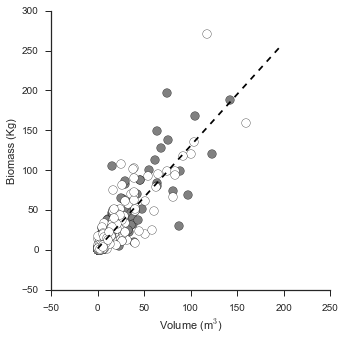

In [75]:
f, (ax) = plt.subplots(1,1, figsize = (5,5))
sns.set_style('ticks')
sns.despine()
spcCol = ['gray','white']
idx = 0
y = []

for num in np.arange(0, 200, 1):
     y.append(intercept + slope*num)
ax.plot(np.arange(0, 200, 1), y, color = 'black', linestyle = '--')

for species in fitData.SPECIES.unique():
    toPlot = fitData[fitData.SPECIES == species]
    ax.scatter(toPlot.VOLUME, toPlot.BIOMASS, 
                color = spcCol[idx], marker = 'o',  
                edgecolor='k', s = 75)
    idx += 1
    
ax.set_ylabel('Biomass (Kg)')
ax.set_xlabel('Volume (m$^{3}$)')

### We should also check these fits as a function of circle plot
That way we can actually create an ensemble of fits, or use the variability in fit parameters in our error propagation framework when we start making monte-carlo draws to estimate biomass.

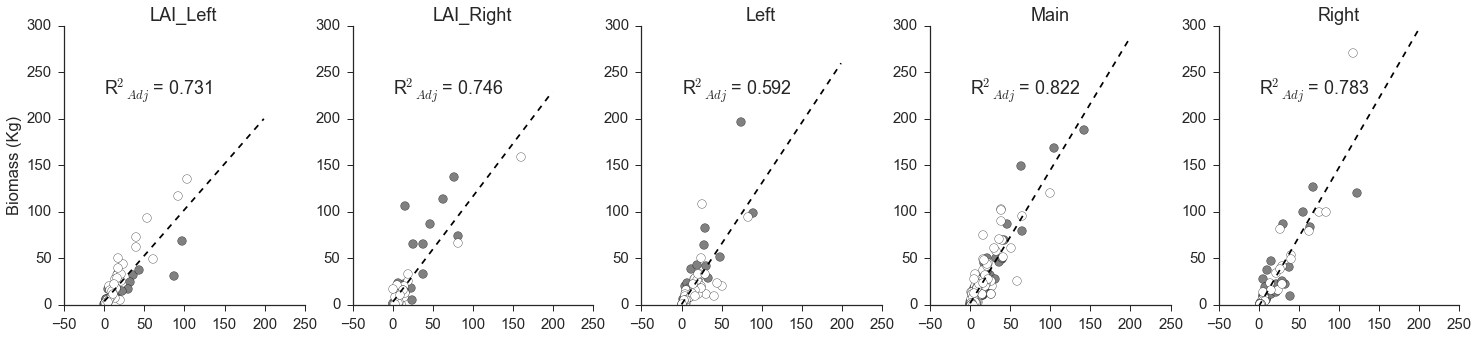

In [119]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (25,5))
axs = f.axes
axix = 0
for plot in np.unique(fitData.PLOT):
    y = []
    idx = 0
    toFit = fitData[fitData.PLOT == plot]
    ols = smf.ols('BIOMASS ~ VOLUME', toFit).fit()
    slope = (ols.params['VOLUME'])
    intercept = (ols.params['Intercept'])
    for num in np.arange(0, 200, 1):
         y.append(intercept + slope*num)
    ax = axs[axix]
    ax.text(0,225,'R$^{2}$$_{Adj}$ = ' + str(np.round(ols.rsquared_adj, 3)))

    ax.plot(np.arange(0, 200, 1), y, color = 'black', linestyle = '--')
    for species in fitData.SPECIES.unique():
        toPlot = toFit[toFit.SPECIES == species]
        ax.scatter(toPlot.VOLUME, toPlot.BIOMASS, 
                    color = spcCol[idx], marker = 'o',  
                    edgecolor='k', s = 75)
        idx  += 1
    ax.set_title(plot)
    ax.set_ylim([0,300])
    axix += 1
sns.despine()
sns.set_context('notebook', font_scale=1.5)
ax1.set_ylabel('Biomass (Kg)')


### Check out the distribution of values from the ground data
Just a few plots to vizualize the distribution of heights, areas, volumes, etc by plot.

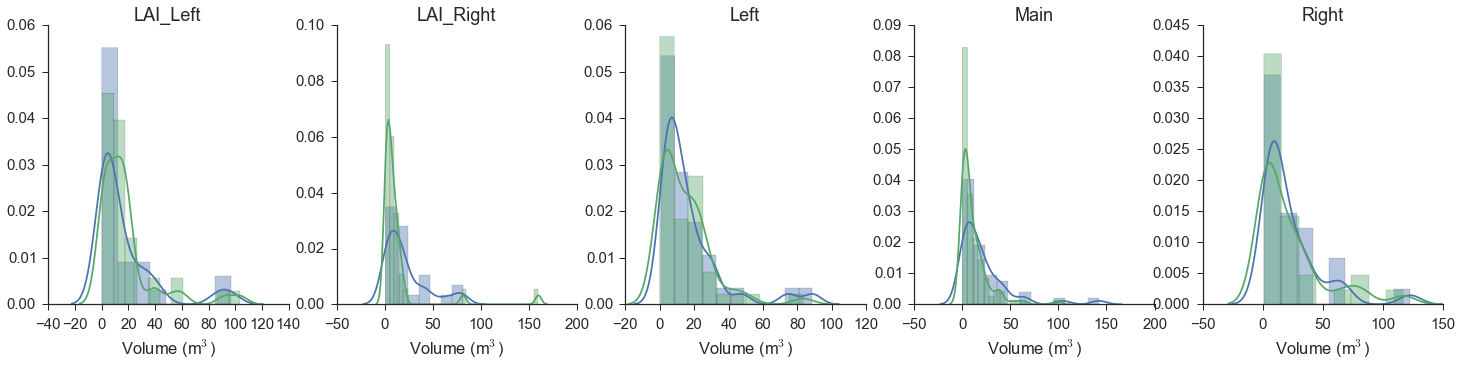

In [125]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (25,5))
axs = f.axes
axix = 0
for plot in np.unique(fitData.PLOT):
    toFit = fitData[fitData.PLOT == plot]
    ax = axs[axix]
    for species in fitData.SPECIES.unique():
        toPlot = toFit[toFit.SPECIES == species]
        sns.distplot(toPlot.VOLUME,ax = ax)
    ax.set_xlabel('Volume (m$^{3}$)')
    ax.set_title(plot)

    axix += 1
sns.despine()

### Visualize the distribution of NDVI and canopy volumes in the vector data
These are the segmented canopies that were generated using a combination of SfM, and morphological filtering operations. Its a pretty robust workflow with the main tuning step being the actual inverse watershed segmentation. Here, the segmentation was generated on a downsampled canopy height raster (0.5 meters), and segments were joined based on height differences >= 1.0 meters from seed to saddle. Prior to segmentation, all heights <= 0.10 meters were set to 0.

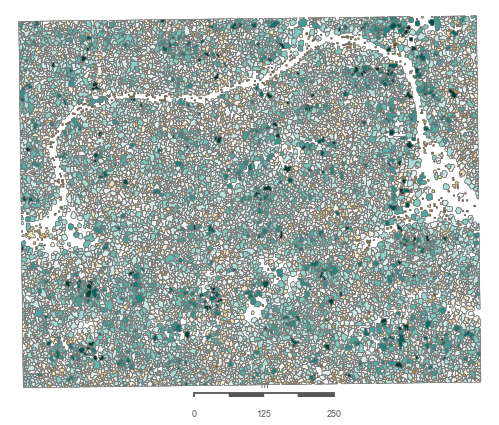

In [71]:
shapeDir = 'Y:/DanK/DeerCanyon/'
f, ax = plt.subplots(1,1, figsize = (12,7))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom(shapeDir + 'DCP_Crowns_4326.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax);

m.readshapefile(shapeDir + 'DCP_Crowns_4326', 'firehist',
    color='gray', zorder=5);

m.drawmapscale(
    coords[0] + 0.005, coords[1],
    coords[0], coords[1],
    250,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1, units='m');

# set up a map dataframe
fireslist = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.firehist]})
for shape in enumerate(df_map['poly']):
    keys, values = m.firehist_info[shape[0]].keys(),m.firehist_info[shape[0]].values()
    fireslist.append(values[10])
df_map['FireRegion'] = fireslist
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('BrBG'))
p.set_array(np.array(fireslist))
p.set_clim([np.ma.min(0),np.ma.max(0.3)])
ax.add_collection(p)



#plt.savefig('FireHistory_Osceola.tif', dpi = 300)

0.118644066154957